In [1]:
# import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##GPU를 쓰기 위한것
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
##초기에 넣어 줄 랜덤 넘버
'''설명
프사이 = X*W+b 
X : [batch, input]
W : [input, bins]
b : [batch, bins]
X를 랜덤넘버로 넣어준다.
batch_size는 이러한 계산 값들의 동일한 앙상블이라고 생각하면 이해하기 쉽다.
넣어주는 랜덤넘버와 결과로 나오는 프사이 스케일이 다르게 input_scale을 따로 지정해 준 이유는 이 값이 랜덤성을 조절하기 때문이다.
bins는 x축 최소 단위의 수 이다.
'''

batch_size = 200
input_scale = 30
bins = 200
iteration = 100000

input = tf.random_normal([batch_size,input_scale])

In [3]:
## Potential
'''양 사이드에서 프사이를 0으로 하게 설정해 놔서 그냥 모두 0으로 둬도 무한 포텐셜 우물이 된다.'''
potential = tf.constant(0.0, shape = [batch_size,bins])

In [4]:
## Weight, bias
'''input으로 random normal의 수가 들어갈 때, tf변수의 이니셜라이져로 xavier를 쓰면 학습을 빨리한다는 정보가 있다.'''
initializer = tf.contrib.layers.xavier_initializer()
weight = tf.Variable(initializer([input_scale, bins]), dtype = tf.float32)
bias = tf.Variable(initializer([bins]), dtype = tf.float32)


In [5]:
## loss
'''우리의 결과를 관찰해 보면 weight는 랜덤인 X와 곱해져 있기 때문에 결과의 랜덤성, bias는 안정성을 나타낸다.
이 loss라는 것은 weigth,bias 텐서의 평균값이다.
학습이 진행되면서 weight와 bias의 경쟁이 진행된다. 즉, 결과가 계속 바뀔것이냐 고정될 것이냐의 싸움이다.
여기서 weight loss와 아주 작은 상수를 곱한 후 코스트에 더해서 같이 미니마이즈 할 경우, bias의 안정성에 힘을 실어줄 수 있다.
bias loss가 weight loss를 압도하는 순간 결과가 안정되는 것을 볼 수 있다.
어느정도 코스트가 낮춰졌을 때 요동치지 않고 한 값으로 수렴하게 도와주는 역할을 한다.'''
w1_loss, b1_loss = tf.nn.l2_loss(weight), tf.nn.l2_loss(bias)

In [6]:
##Psi
'''binsnorm으로 프사이 제곱의 합을 1로 normalize시키기 위한 분모.
홈페이지의 자료에는 편의상 1로 하지 않았다.'''
binsnorm = tf.sqrt(tf.cast(bins, tf.float32))
psi = tf.matmul(input, weight) + bias
psi = tf.divide(psi,tf.sqrt(tf.reduce_mean(tf.square(psi), axis = -1, keepdims = True)))/binsnorm

In [7]:
##Cost
'''프사이를 엇갈리게 빼서 2차 미분을 하는 스킬을 쓴다.
에너지의 평균을 코스트로 잡고 이를 미니마이즈하면 그라운드 스테이트가 나온다는 개념을 사용했다.'''
zeroten = tf.zeros([batch_size,1], tf.float32)
psil = tf.concat([psi[:,1:],zeroten],1)
psir = tf.concat([zeroten,psi[:,:-1]],1)
energy = tf.reduce_mean(tf.subtract(tf.multiply(tf.square(psi),tf.add(potential,1.*bins*bins)),tf.multiply(tf.multiply((tf.add(psil,psir)),psi),0.5*bins*bins)), axis=-1, keepdims=True)*bins
cost = tf.reduce_mean(energy)+0.01*(w1_loss)


In [8]:
##Optimizer
'''현재 머신러닝에 가장 많이 사용하는 아담옵티마이져를 사용했다.
학습속도가 빠른반면 중간중간에 로컬미니멈에 안빠지기 위한 랜덤이 있다.
러닝레이트가 그레디언트 디센트와 조금 다르게 적용돼서 왠만하면 안만진다.'''
train = tf.train.AdamOptimizer(learning_rate=0.008).minimize(cost)

In [9]:
# If you want to use CPU
config = tf.ConfigProto(device_count = {'GPU': 0})

sess = tf.Session(config=config)

# If you want to use GPU
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# sess = tf.Session(config=config)

In [10]:
init = tf.global_variables_initializer()
sess.run(init)

iteration=0, cost=36702.207031
W1_loss=26.558376, B1_loss=0.475979


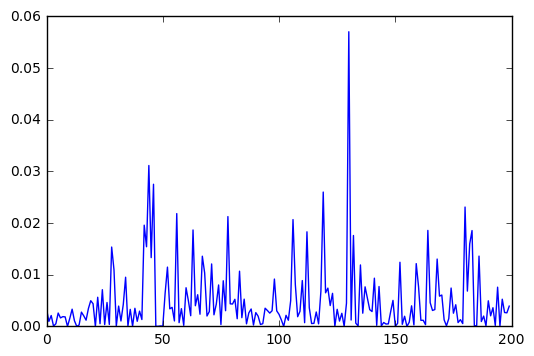

iteration=1000, cost=45.084282
W1_loss=66.844437, B1_loss=17.275867


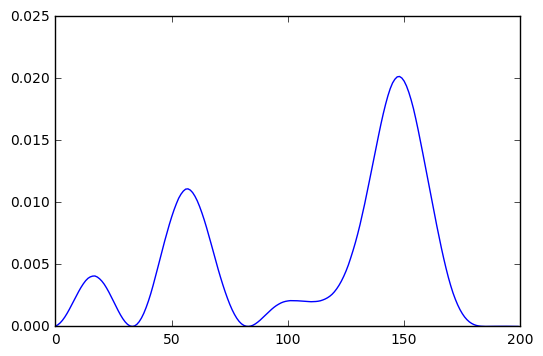

iteration=2000, cost=24.802635
W1_loss=83.187317, B1_loss=19.461376


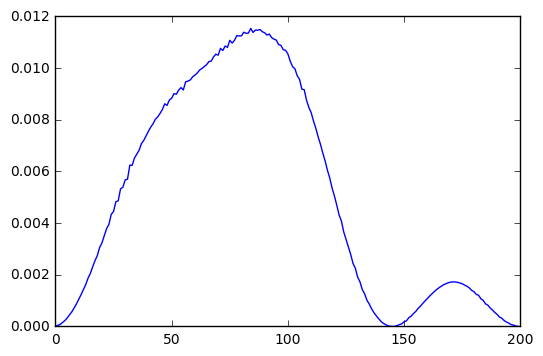

iteration=3000, cost=21.297346
W1_loss=112.994820, B1_loss=26.817785


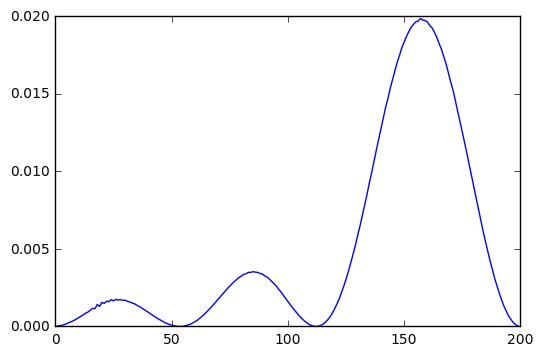

iteration=4000, cost=22.620987
W1_loss=140.356201, B1_loss=35.640411


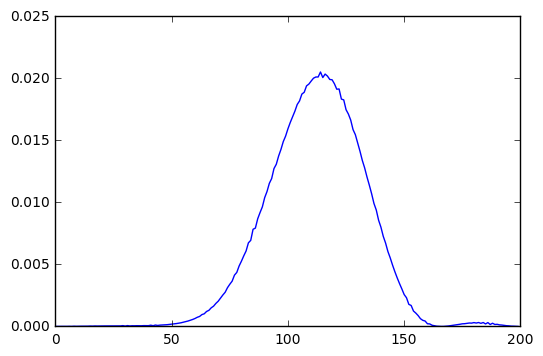

iteration=5000, cost=17.937803
W1_loss=159.602219, B1_loss=38.419720


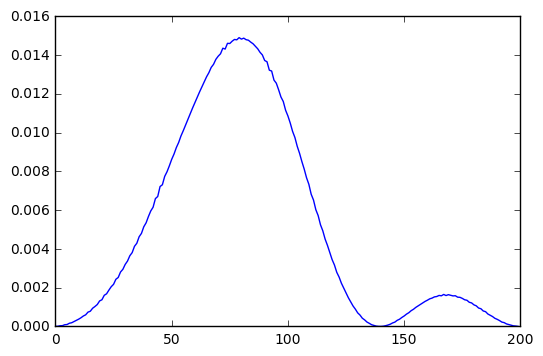

iteration=6000, cost=33.170048
W1_loss=182.462250, B1_loss=49.612976


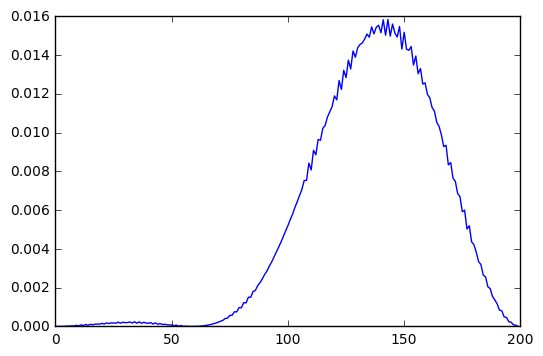

iteration=7000, cost=20.741444
W1_loss=195.896301, B1_loss=60.086266


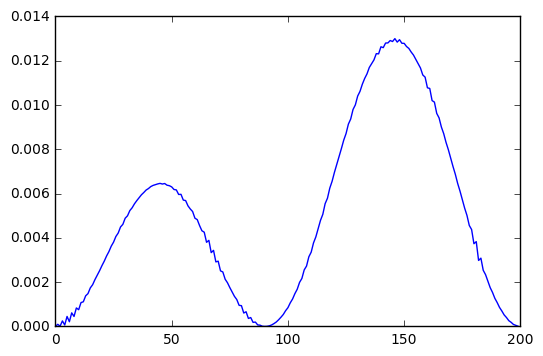

iteration=8000, cost=14.926527
W1_loss=203.394073, B1_loss=69.214287


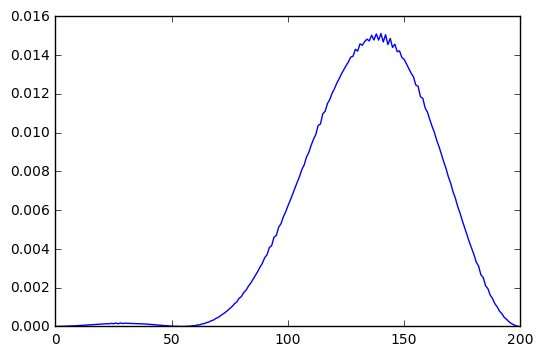

iteration=9000, cost=15.480739
W1_loss=209.406509, B1_loss=61.008774


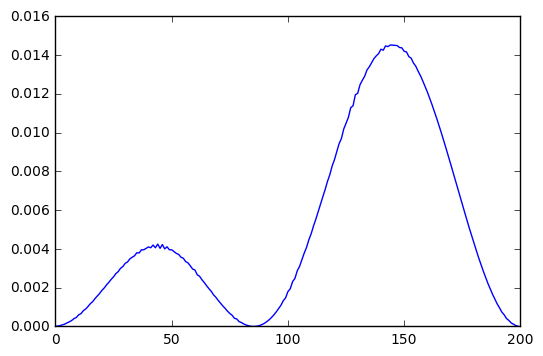

iteration=10000, cost=14.802128
W1_loss=218.753906, B1_loss=55.147423


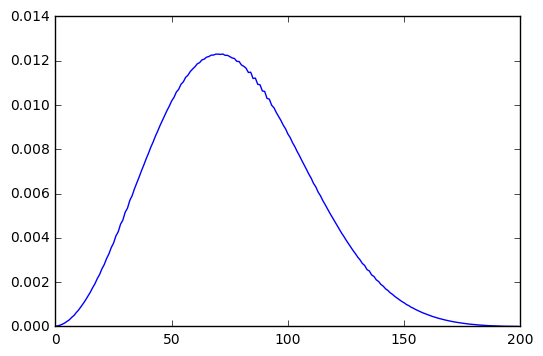

iteration=11000, cost=14.528130
W1_loss=228.054184, B1_loss=53.362144


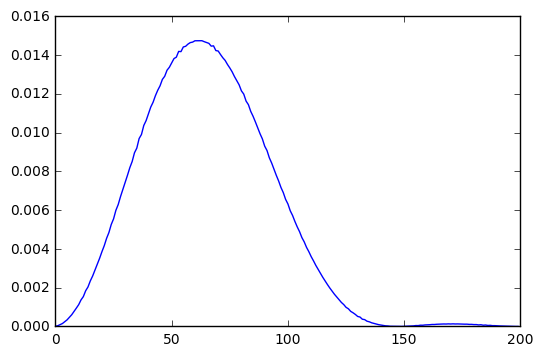

iteration=12000, cost=12.737958
W1_loss=238.421738, B1_loss=60.850540


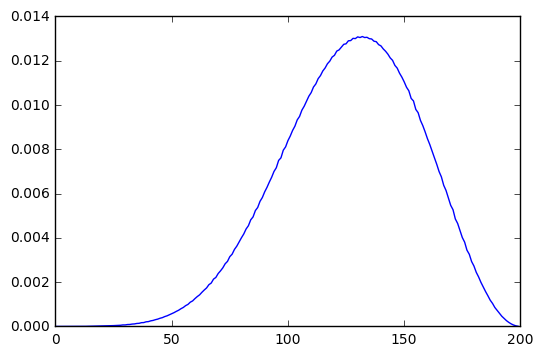

iteration=13000, cost=14.354724
W1_loss=242.209412, B1_loss=62.443520


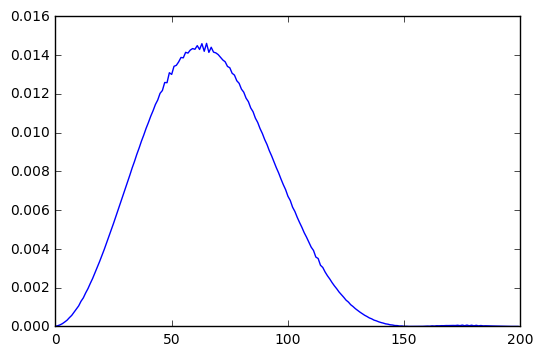

iteration=14000, cost=13.811111
W1_loss=243.910553, B1_loss=68.206924


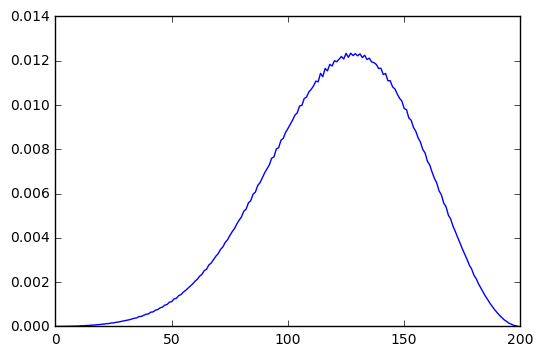

iteration=15000, cost=13.678226
W1_loss=243.176208, B1_loss=75.822662


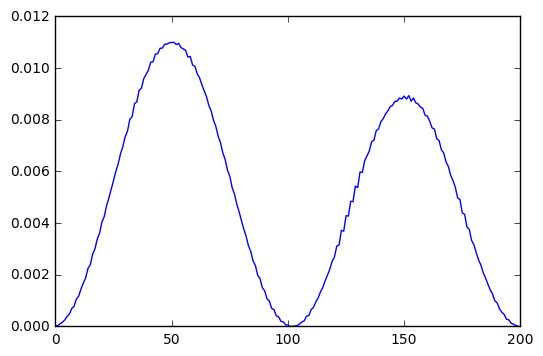

iteration=16000, cost=15.758044
W1_loss=239.631958, B1_loss=85.391510


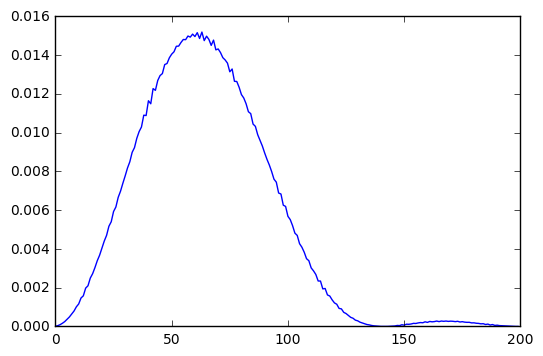

iteration=17000, cost=13.190914
W1_loss=232.905441, B1_loss=97.940201


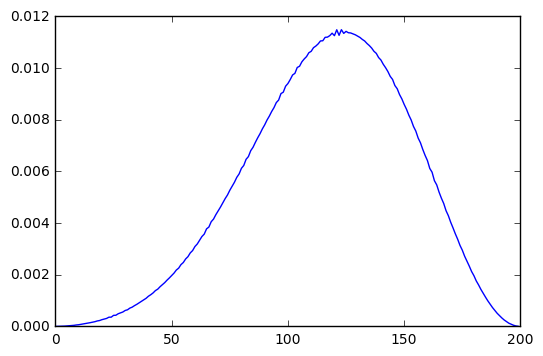

iteration=18000, cost=13.659082
W1_loss=223.334549, B1_loss=115.676315


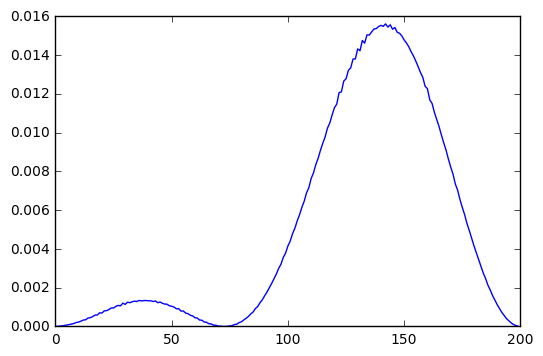

iteration=19000, cost=12.636105
W1_loss=208.754974, B1_loss=138.546631


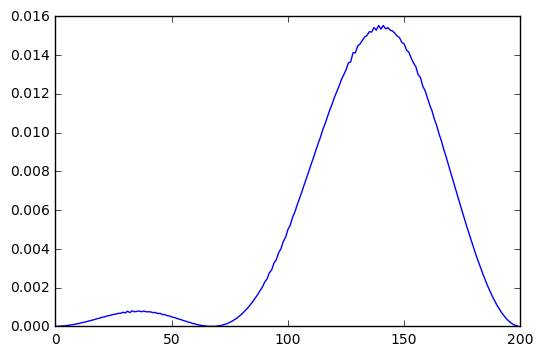

iteration=20000, cost=12.465927
W1_loss=187.188904, B1_loss=167.656586


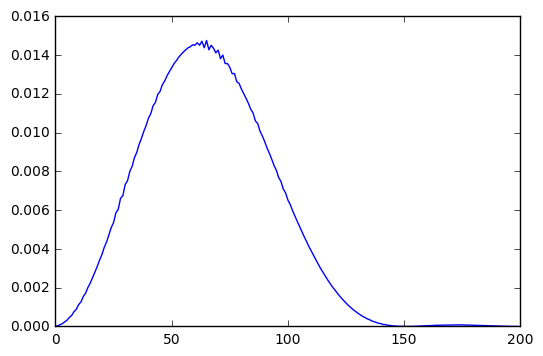

iteration=21000, cost=10.899573
W1_loss=154.800873, B1_loss=205.094788


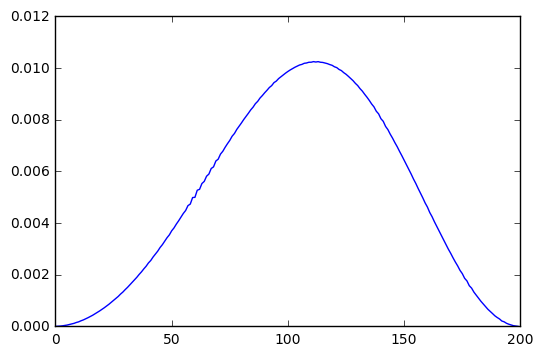

iteration=22000, cost=10.476915
W1_loss=108.489197, B1_loss=256.083191


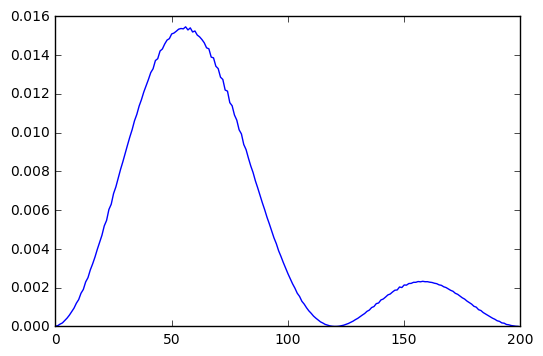

iteration=23000, cost=9.035323
W1_loss=52.214294, B1_loss=320.954834


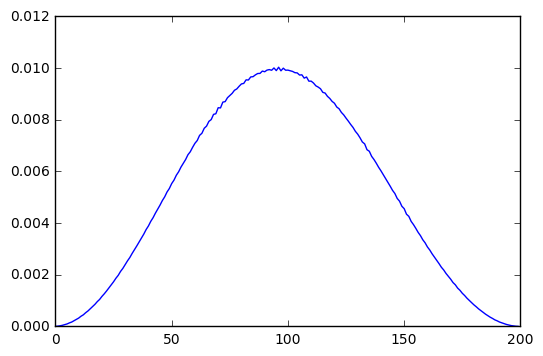

iteration=24000, cost=5.818613
W1_loss=20.274693, B1_loss=354.451447


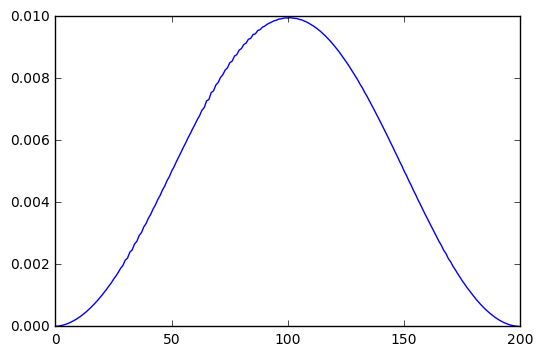

iteration=25000, cost=5.019966
W1_loss=11.567062, B1_loss=359.128052


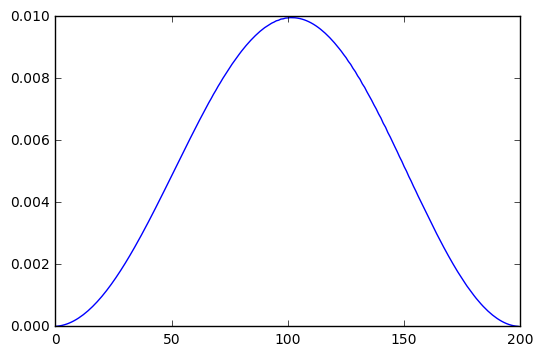

iteration=26000, cost=5.299381
W1_loss=4.915518, B1_loss=373.338013


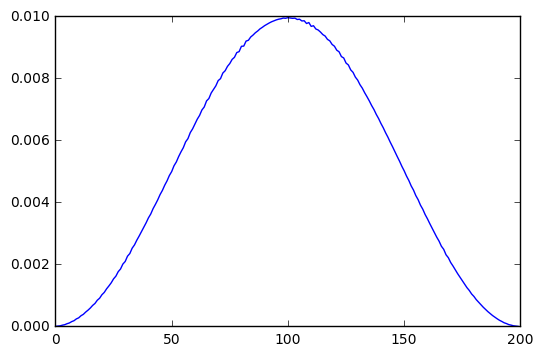

iteration=27000, cost=5.212883
W1_loss=1.653965, B1_loss=395.481445


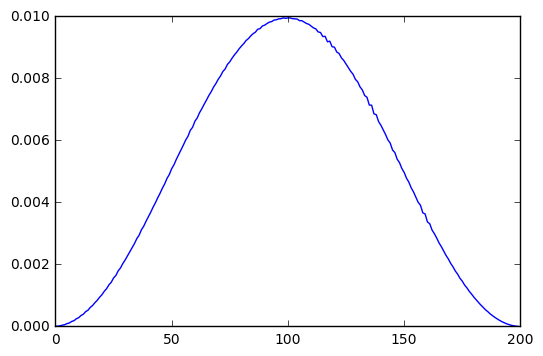

iteration=28000, cost=5.037664
W1_loss=0.486654, B1_loss=423.870728


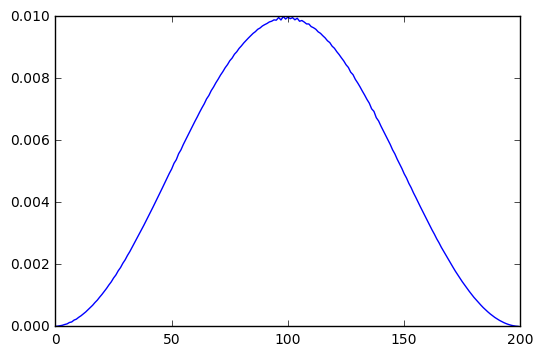

iteration=29000, cost=5.409482
W1_loss=0.130829, B1_loss=455.389893


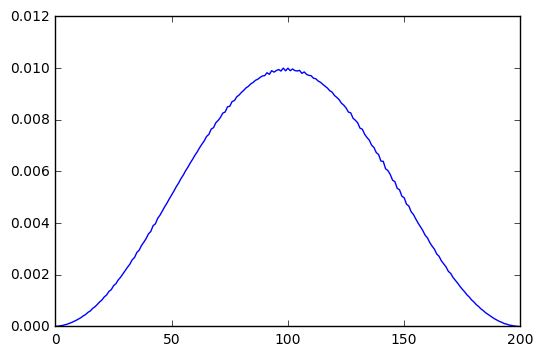

iteration=30000, cost=5.025819
W1_loss=0.033350, B1_loss=487.271851


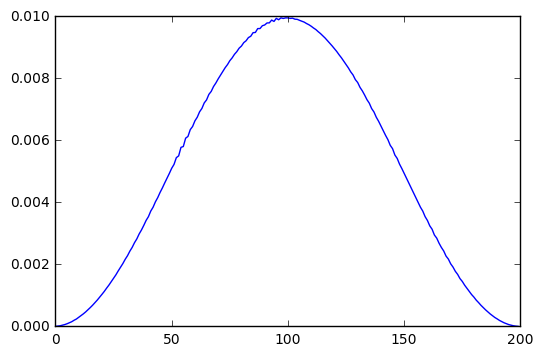

iteration=31000, cost=5.025020
W1_loss=0.008761, B1_loss=520.772705


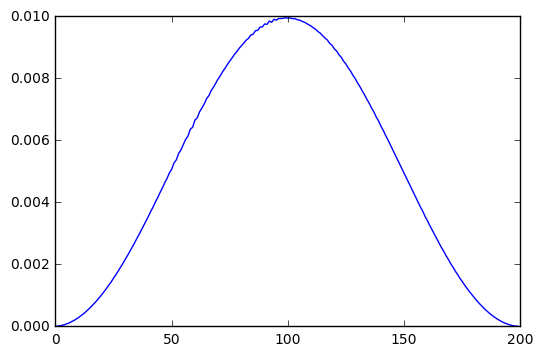

iteration=32000, cost=4.961314
W1_loss=0.002150, B1_loss=552.007751


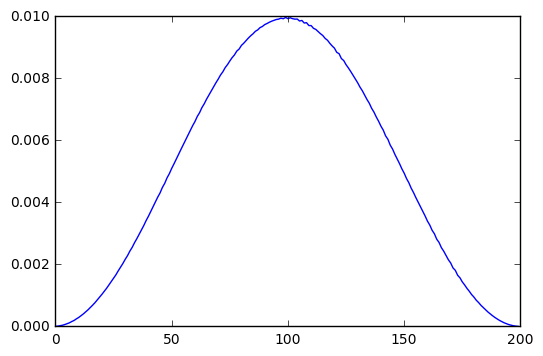

iteration=33000, cost=5.269149
W1_loss=0.003237, B1_loss=584.660095


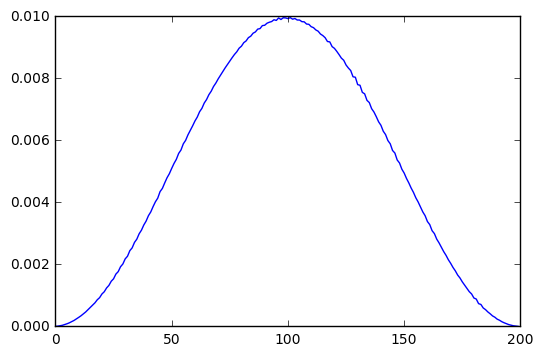

iteration=34000, cost=5.073398
W1_loss=0.001603, B1_loss=618.365845


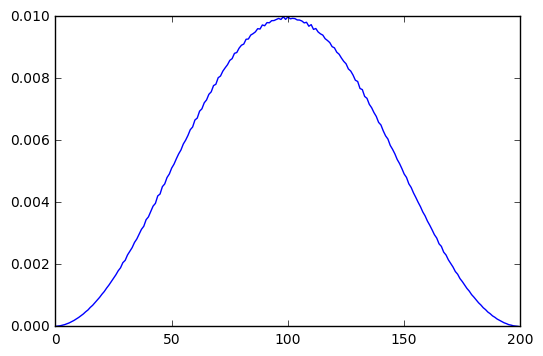

iteration=35000, cost=5.102367
W1_loss=0.001731, B1_loss=650.988892


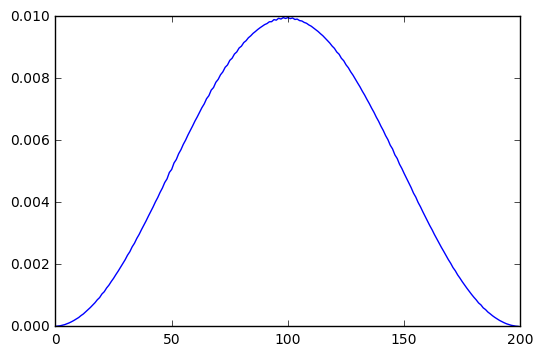

iteration=36000, cost=5.002337
W1_loss=0.001346, B1_loss=688.017700


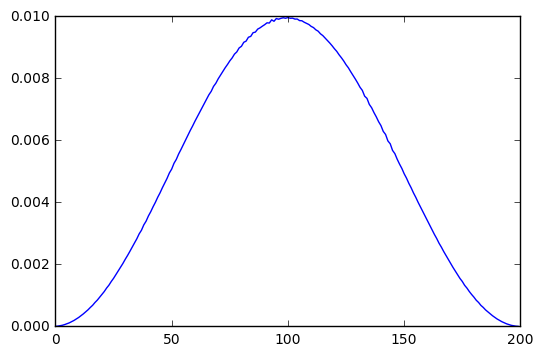

iteration=37000, cost=5.130364
W1_loss=0.002272, B1_loss=721.769165


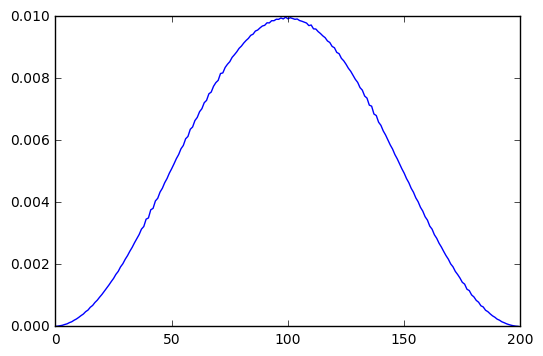

iteration=38000, cost=5.092353
W1_loss=0.001922, B1_loss=751.382935


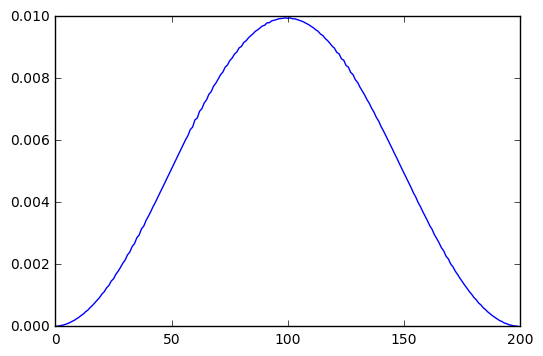

iteration=39000, cost=5.001778
W1_loss=0.001225, B1_loss=786.113159


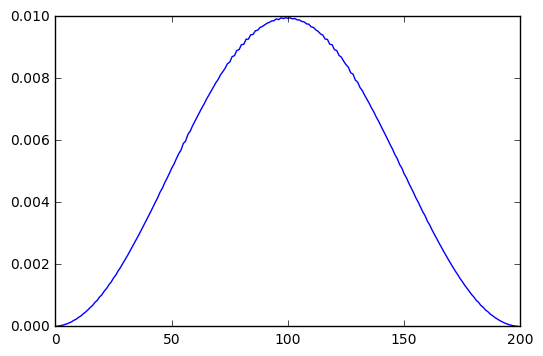

iteration=40000, cost=4.924711
W1_loss=0.000558, B1_loss=823.755371


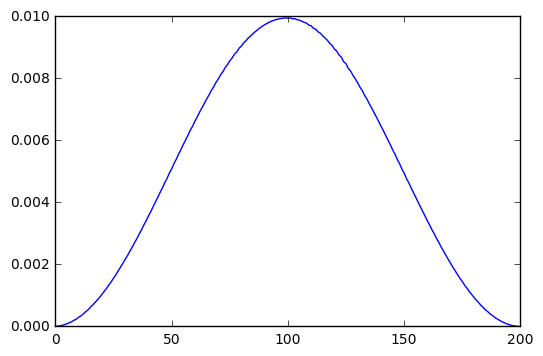

iteration=41000, cost=5.077249
W1_loss=0.002256, B1_loss=854.245789


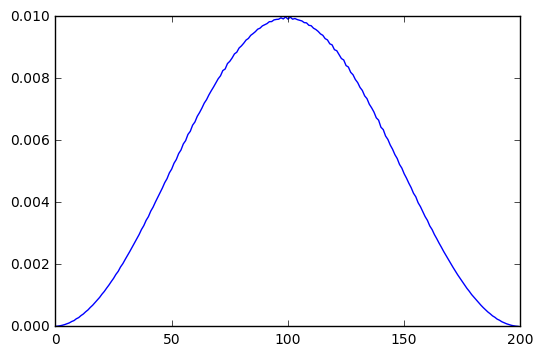

iteration=42000, cost=4.982709
W1_loss=0.001106, B1_loss=888.269043


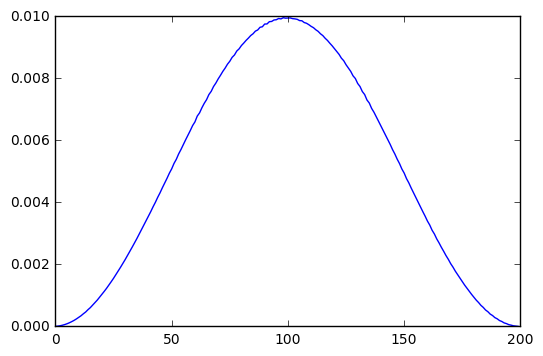

iteration=43000, cost=5.115774
W1_loss=0.002666, B1_loss=922.816284


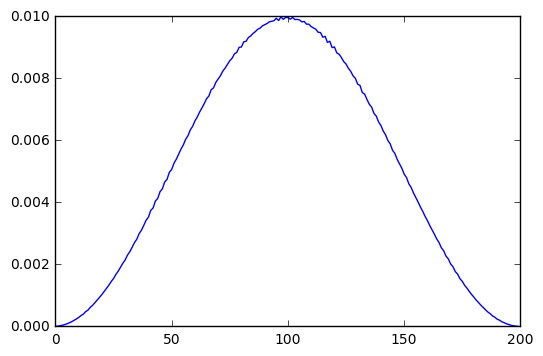

iteration=44000, cost=5.000717
W1_loss=0.001569, B1_loss=958.349976


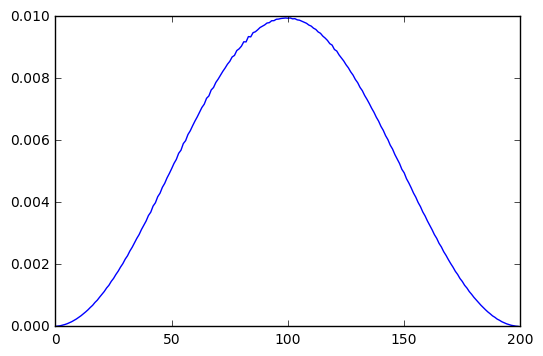

iteration=45000, cost=5.085864
W1_loss=0.002642, B1_loss=995.985107


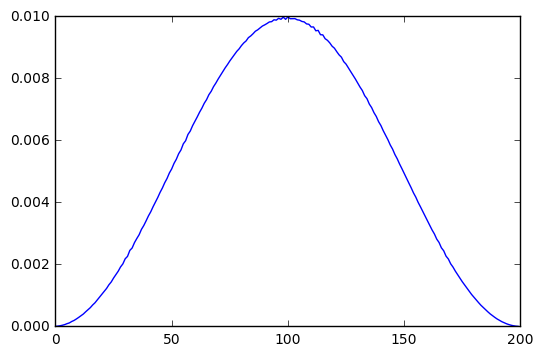

iteration=46000, cost=5.004025
W1_loss=0.001545, B1_loss=1026.620728


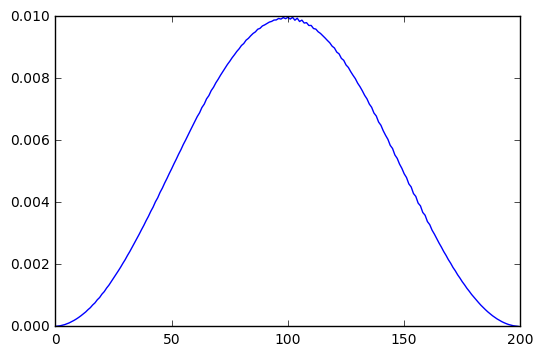

iteration=47000, cost=5.032659
W1_loss=0.001989, B1_loss=1059.379883


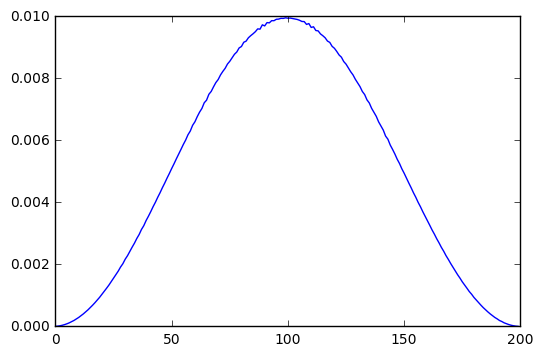

iteration=48000, cost=4.980959
W1_loss=0.001412, B1_loss=1096.782227


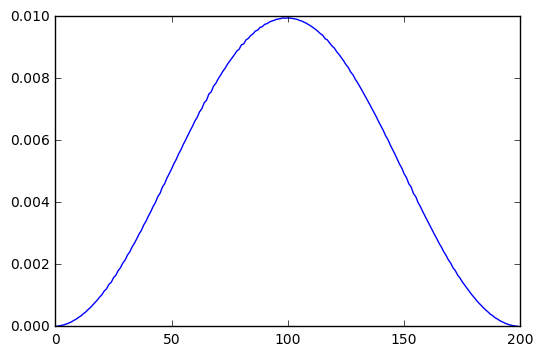

iteration=49000, cost=4.932066
W1_loss=0.000710, B1_loss=1131.217163


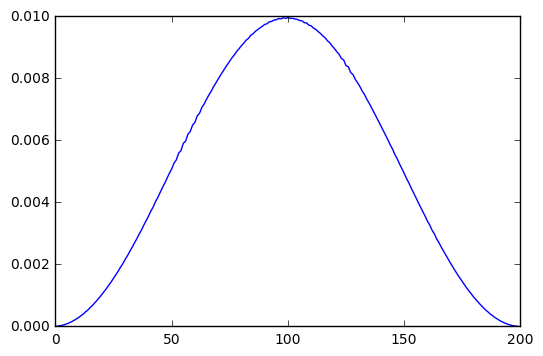

iteration=50000, cost=4.935733
W1_loss=0.000742, B1_loss=1164.540771


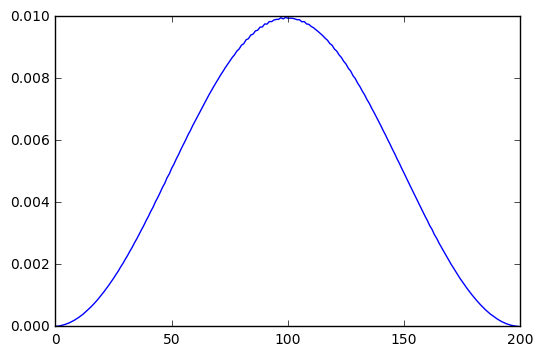

iteration=51000, cost=5.051816
W1_loss=0.002408, B1_loss=1197.287109


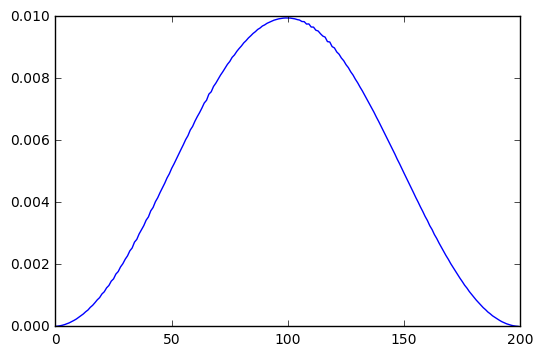

iteration=52000, cost=5.051927
W1_loss=0.002581, B1_loss=1236.481445


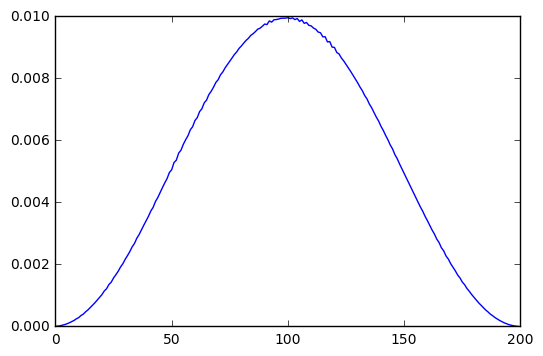

iteration=53000, cost=4.962195
W1_loss=0.001135, B1_loss=1272.518555


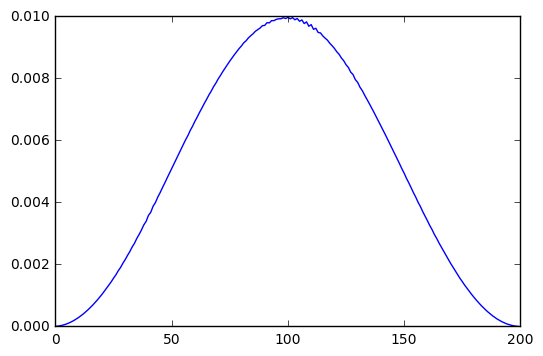

iteration=54000, cost=4.942618
W1_loss=0.000986, B1_loss=1302.499390


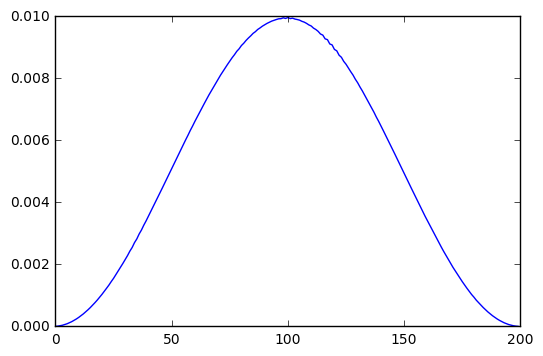

iteration=55000, cost=4.986162
W1_loss=0.001782, B1_loss=1339.031738


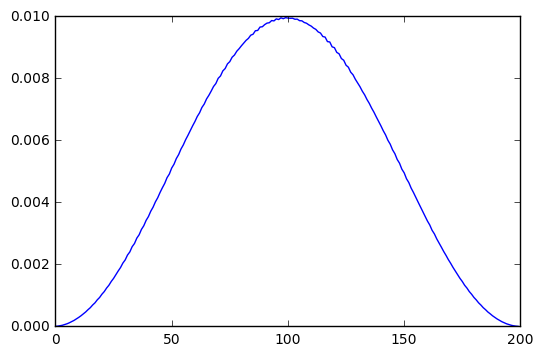

iteration=56000, cost=4.983748
W1_loss=0.001729, B1_loss=1378.313477


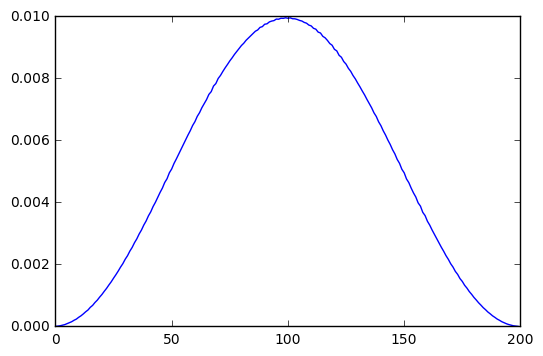

iteration=57000, cost=5.021078
W1_loss=0.002280, B1_loss=1407.912231


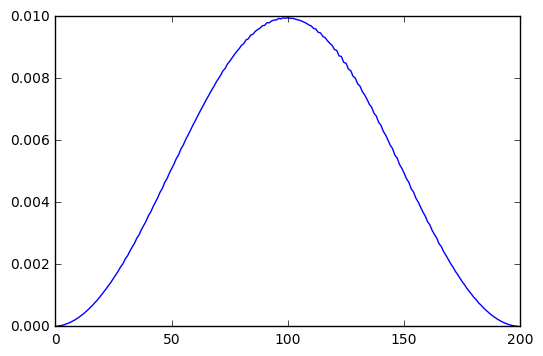

iteration=58000, cost=5.008878
W1_loss=0.002243, B1_loss=1446.172119


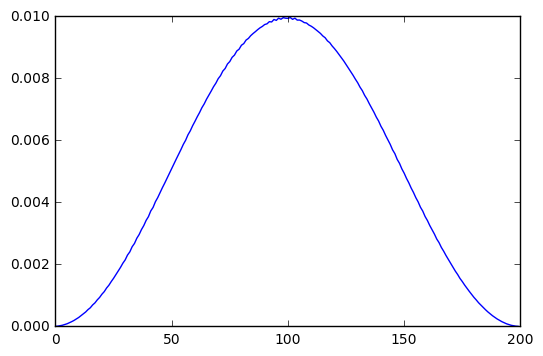

iteration=59000, cost=5.012015
W1_loss=0.002310, B1_loss=1479.839111


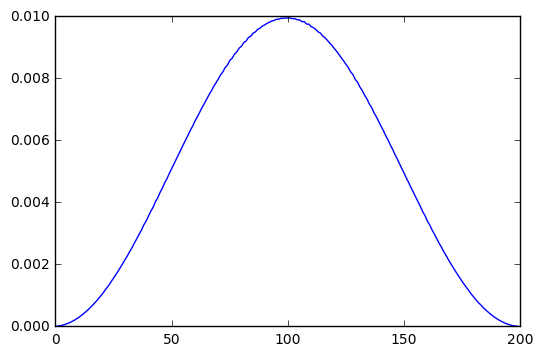

iteration=60000, cost=5.005788
W1_loss=0.002461, B1_loss=1515.762939


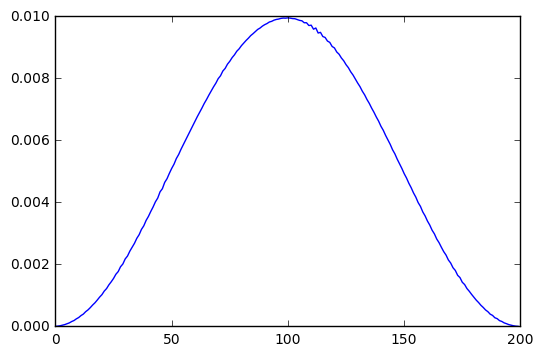

iteration=61000, cost=4.974454
W1_loss=0.001776, B1_loss=1549.527832


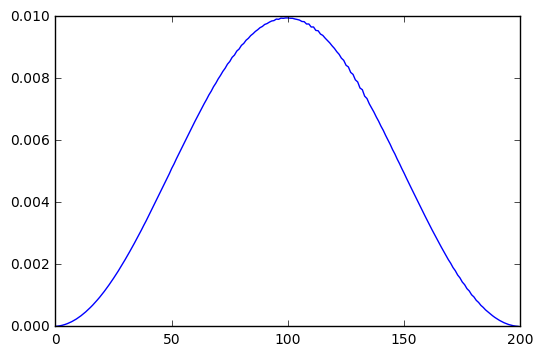

iteration=62000, cost=4.952774
W1_loss=0.001411, B1_loss=1586.576904


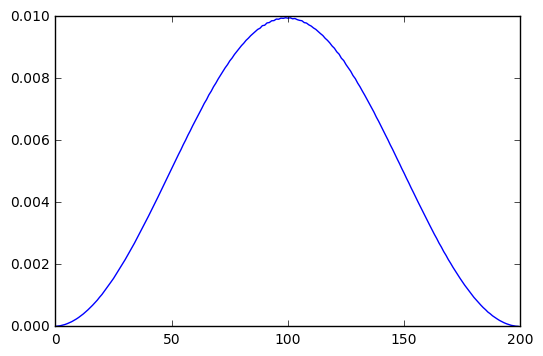

iteration=63000, cost=4.936807
W1_loss=0.001133, B1_loss=1625.167847


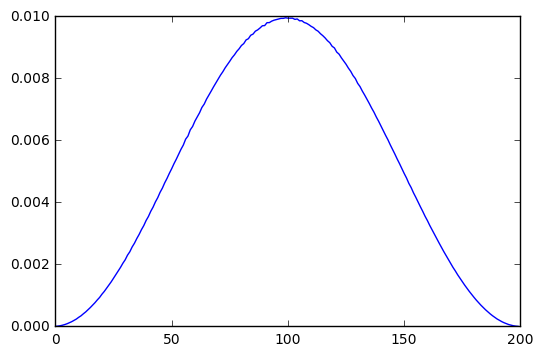

iteration=64000, cost=4.973457
W1_loss=0.001785, B1_loss=1658.900879


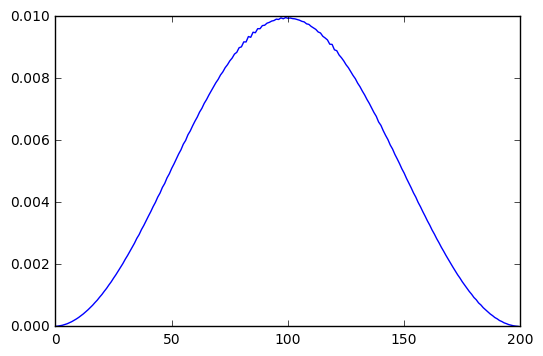

iteration=65000, cost=4.984312
W1_loss=0.002139, B1_loss=1696.622559


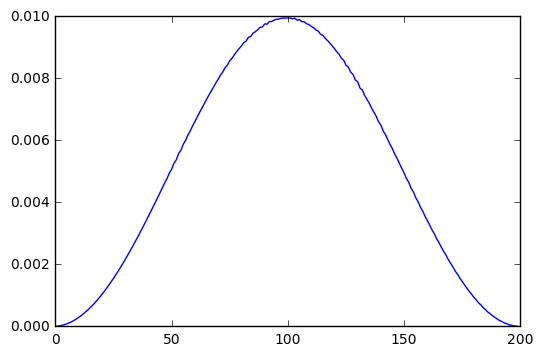

iteration=66000, cost=4.916038
W1_loss=0.000702, B1_loss=1730.378174


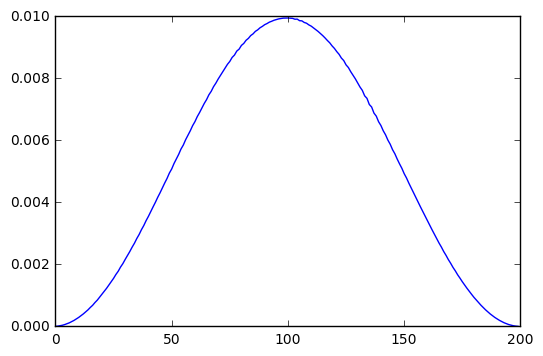

iteration=67000, cost=4.990520
W1_loss=0.002190, B1_loss=1762.087769


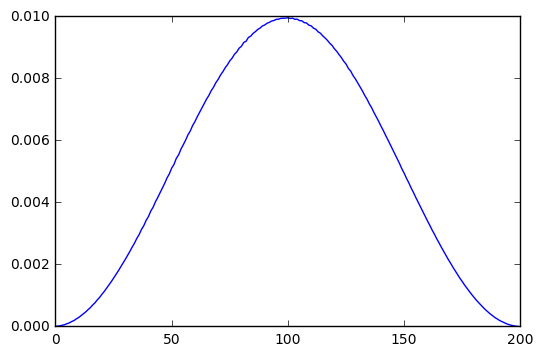

iteration=68000, cost=4.991701
W1_loss=0.002360, B1_loss=1796.977783


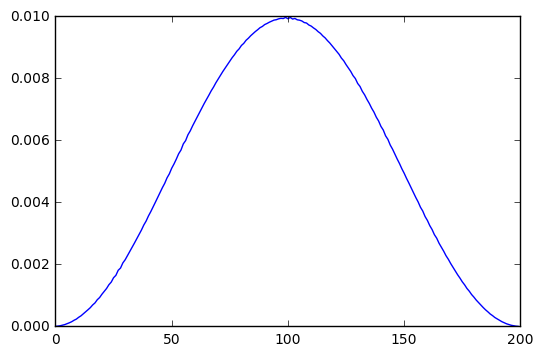

iteration=69000, cost=5.041119
W1_loss=0.003570, B1_loss=1833.221436


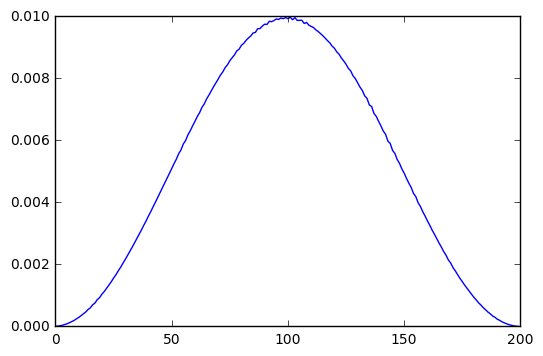

iteration=70000, cost=5.000281
W1_loss=0.002712, B1_loss=1871.386353


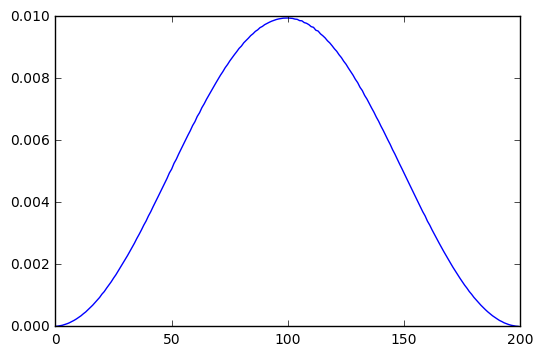

iteration=71000, cost=4.931818
W1_loss=0.001065, B1_loss=1907.456543


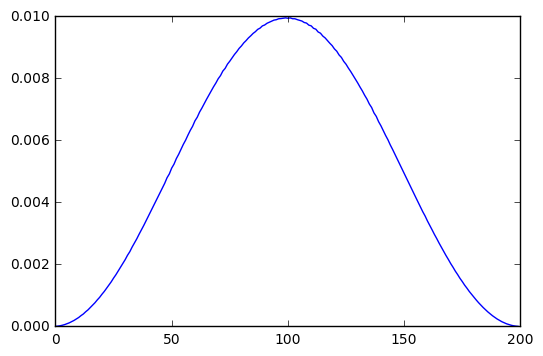

iteration=72000, cost=4.934051
W1_loss=0.001270, B1_loss=1943.049194


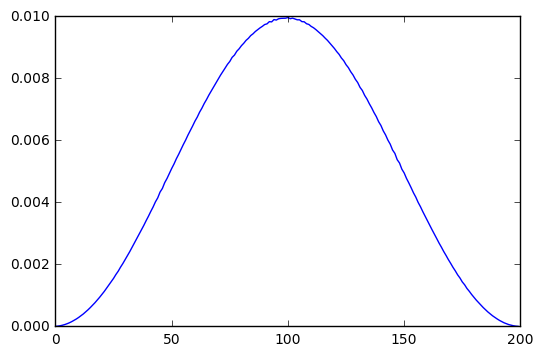

iteration=73000, cost=4.923093
W1_loss=0.000961, B1_loss=1974.146240


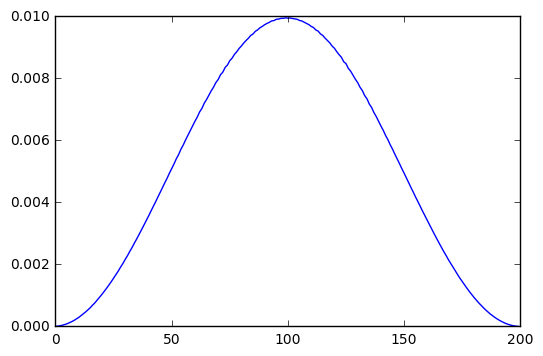

iteration=74000, cost=4.961893
W1_loss=0.001967, B1_loss=2011.951416


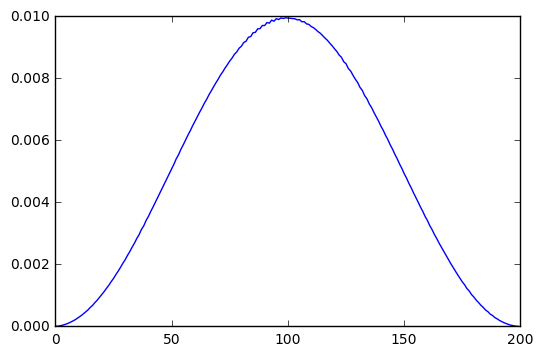

iteration=75000, cost=4.964035
W1_loss=0.002033, B1_loss=2047.784912


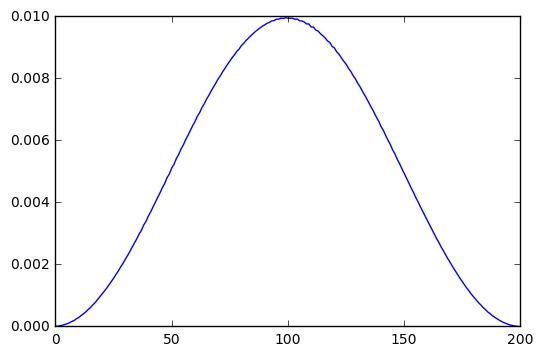

iteration=76000, cost=4.919209
W1_loss=0.000922, B1_loss=2081.402832


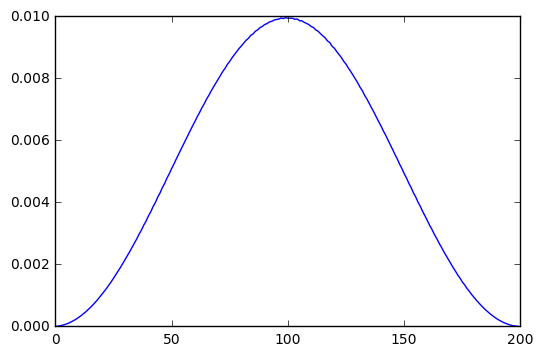

iteration=77000, cost=4.912074
W1_loss=0.000653, B1_loss=2115.657227


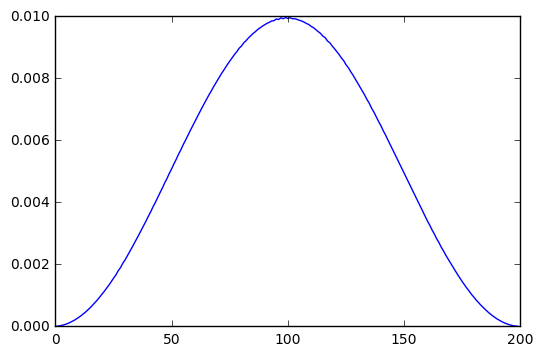

iteration=78000, cost=4.995131
W1_loss=0.002957, B1_loss=2153.068115


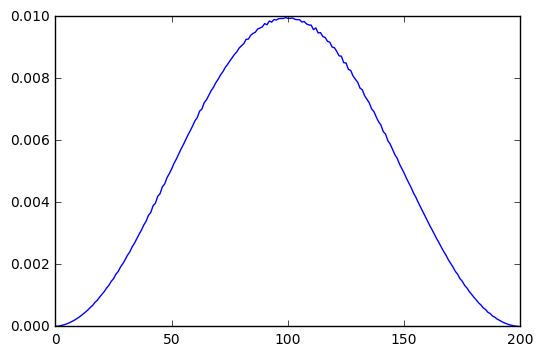

iteration=79000, cost=4.940003
W1_loss=0.001553, B1_loss=2187.261230


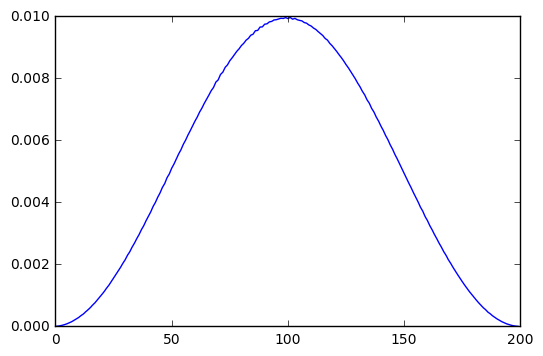

iteration=80000, cost=4.952976
W1_loss=0.001858, B1_loss=2221.145996


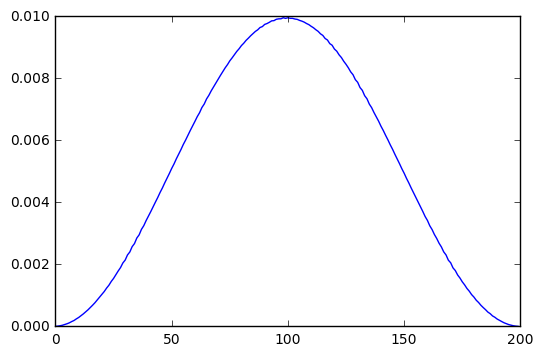

iteration=81000, cost=4.937781
W1_loss=0.001478, B1_loss=2259.170898


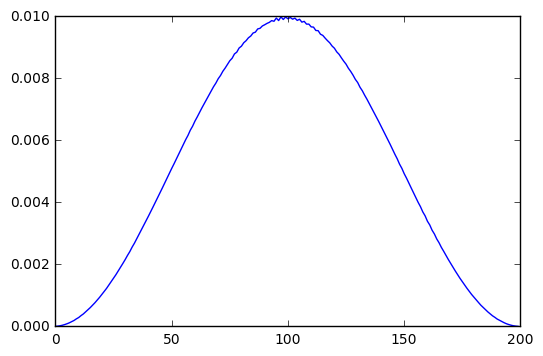

iteration=82000, cost=4.942522
W1_loss=0.001507, B1_loss=2295.903320


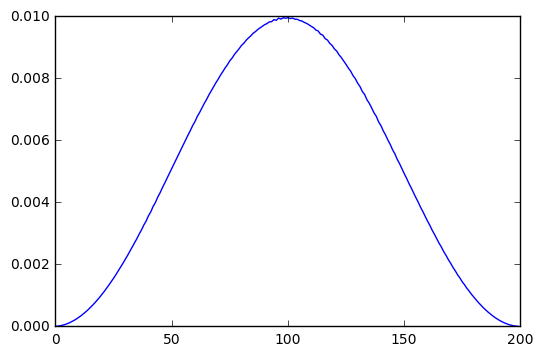

iteration=83000, cost=4.905589
W1_loss=0.000604, B1_loss=2332.180176


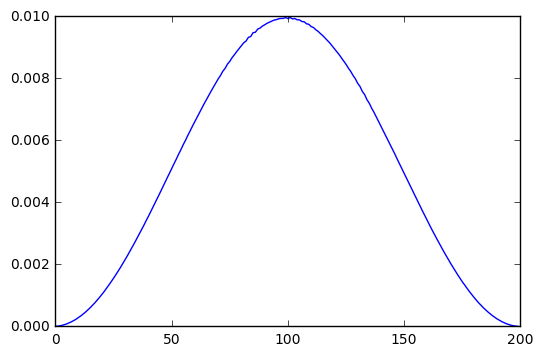

iteration=84000, cost=4.949792
W1_loss=0.001979, B1_loss=2370.306152


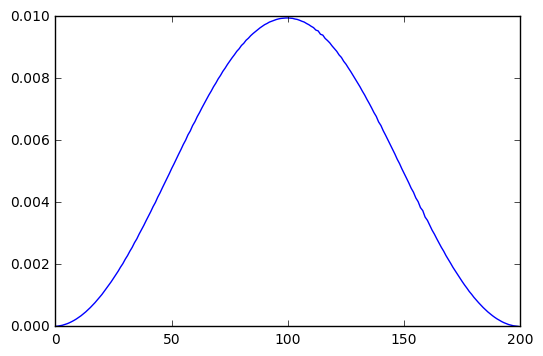

iteration=85000, cost=4.912628
W1_loss=0.000868, B1_loss=2404.619141


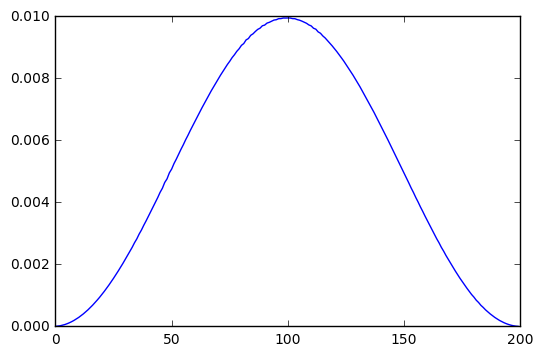

iteration=86000, cost=4.916381
W1_loss=0.000861, B1_loss=2438.718750


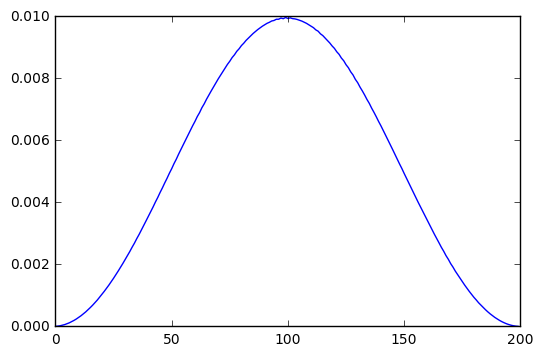

iteration=87000, cost=4.972801
W1_loss=0.002840, B1_loss=2475.549072


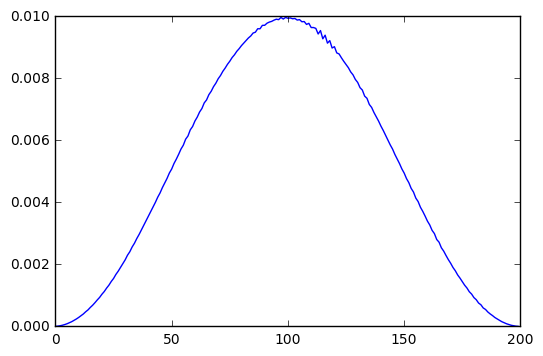

iteration=88000, cost=4.917689
W1_loss=0.000996, B1_loss=2514.721191


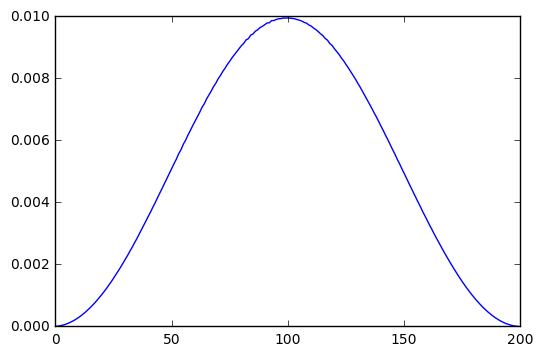

iteration=89000, cost=4.905328
W1_loss=0.000662, B1_loss=2548.939941


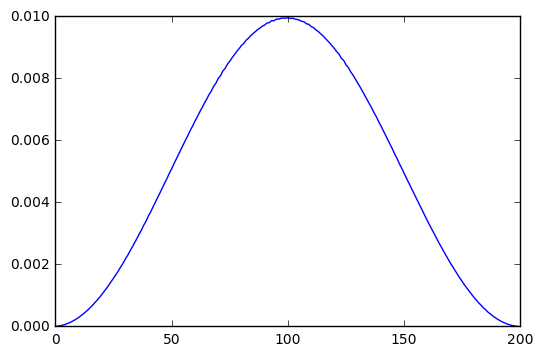

iteration=90000, cost=4.903741
W1_loss=0.000597, B1_loss=2584.032715


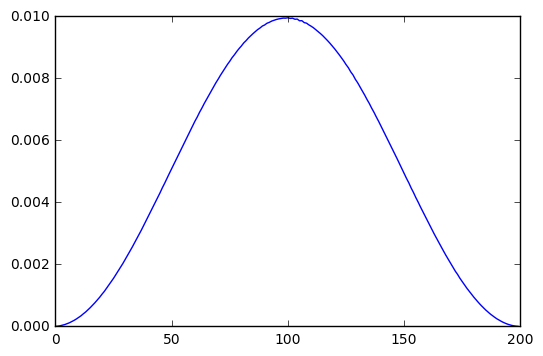

iteration=91000, cost=4.964752
W1_loss=0.002433, B1_loss=2617.980469


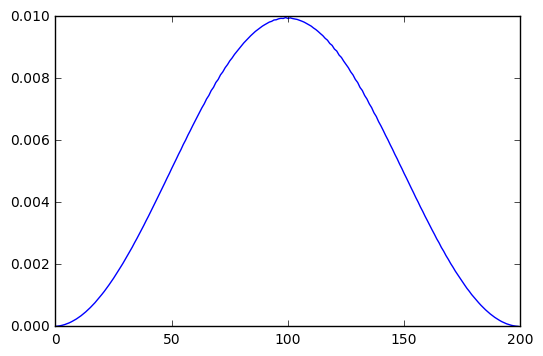

iteration=92000, cost=4.964690
W1_loss=0.002788, B1_loss=2659.863281


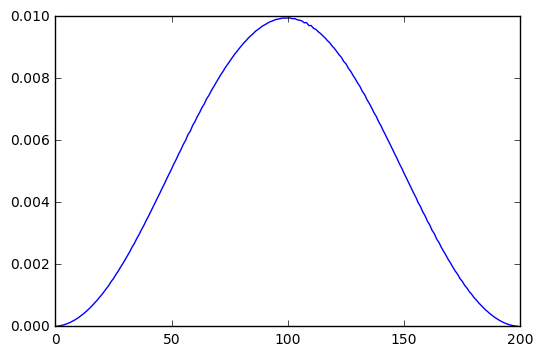

iteration=93000, cost=4.936308
W1_loss=0.001626, B1_loss=2692.418213


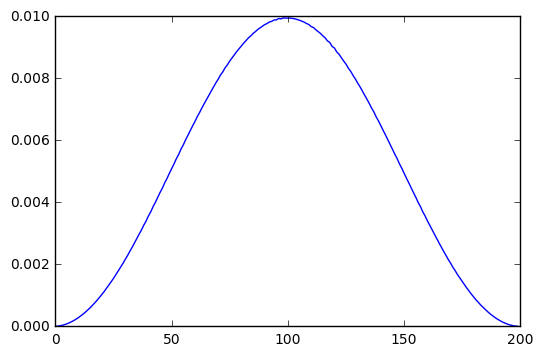

iteration=94000, cost=4.931166
W1_loss=0.001523, B1_loss=2729.095703


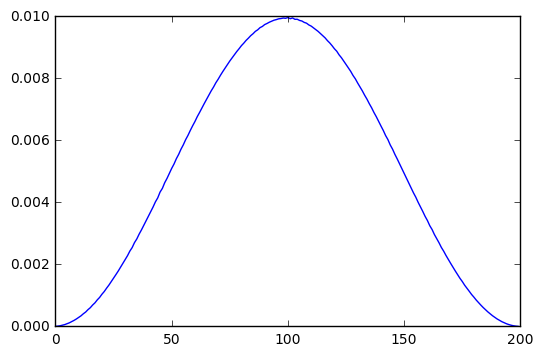

iteration=95000, cost=4.924538
W1_loss=0.001374, B1_loss=2767.594482


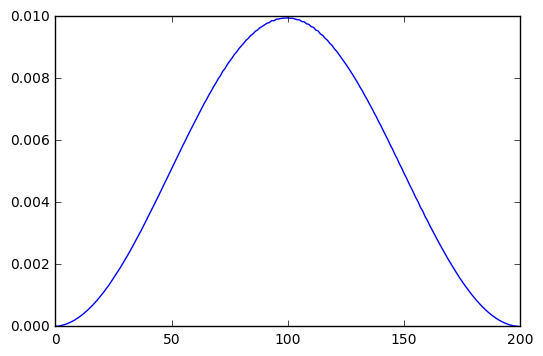

iteration=96000, cost=4.926802
W1_loss=0.001542, B1_loss=2803.466797


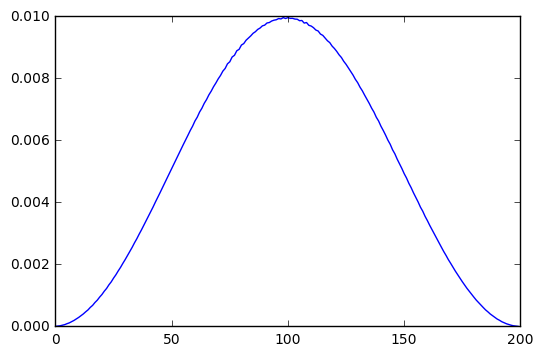

iteration=97000, cost=4.930135
W1_loss=0.001592, B1_loss=2835.459229


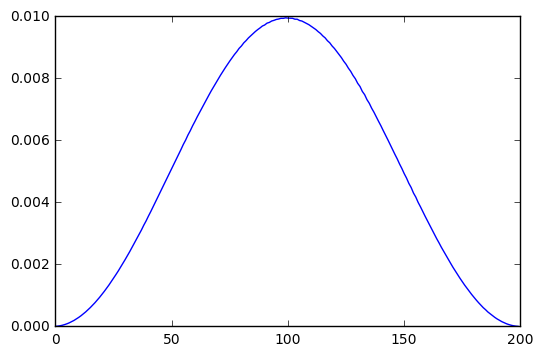

iteration=98000, cost=5.024021
W1_loss=0.004974, B1_loss=2872.800781


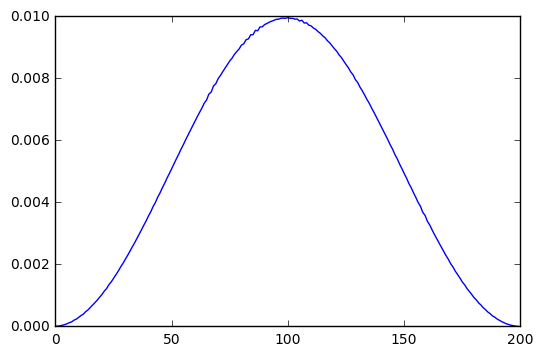

iteration=99000, cost=4.924841
W1_loss=0.001443, B1_loss=2911.665283


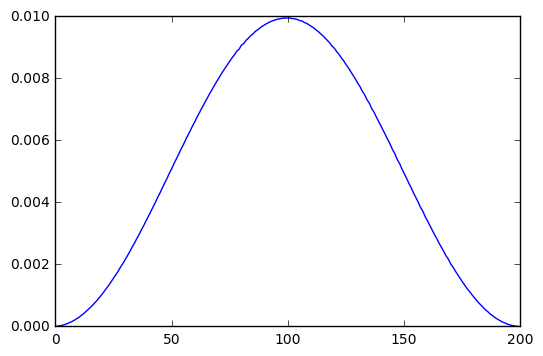

In [11]:
resultsum = 0
for i in range (iteration):
    sess.run(train)
    if i % 1000 == 0:
        psi_now, cost_now,w1_loss_v,b1_loss_v = sess.run([psi, cost, w1_loss, b1_loss])
        prob_now = psi_now**2
        print("iteration=%d, cost=%f" % (i, cost_now))
        print("W1_loss=%f, B1_loss=%f" % (w1_loss_v, b1_loss_v))
        plt.plot(prob_now[0])
        plt.show()

In [12]:
'''
2018.10.08 첫 번째 수정
1. normalization 수정
2. weight, bias initialization by tf.random_normal_initializer()
- 코스트가 줄어드는 경향성이 확실하게 보인다.
3. 그래프 추가
'''

'\n2018.10.08 첫 번째 수정\n1. normalization 수정\n2. weight, bias initialization by tf.random_normal_initializer()\n- 코스트가 줄어드는 경향성이 확실하게 보인다.\n3. 그래프 추가\n'